# Recurrent Neural Network

Basic RNN and LSTM based RNN models that are used to predict the language for a given name, from the PyTorch for Torch users tutorial.

Import packages

In [4]:
from io import open
import glob
import os
import unicodedata
import random
import string
import torch
import numpy as np
import time
import math

# Convert Data from Unicode to ASCII

In [7]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print ('n_letters',n_letters)

# Convert a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print ('n_categories', n_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
n_letters 57
Slusarski
n_categories 18


# Test language Dictionary

Print a list of names from a supported language

In [9]:
print(category_lines['Arabic'][ :5])
print(category_lines['Spanish'][ :5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


# Helper Functions to Convert Names to One-Hot Encoded Tensors

In [10]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a (1 x n_letters) Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a (line_length x 1 x n_letters), or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Basic RNN

This RNN (from the PyTorch for Torch users tutorial) has 2 linear layers which operate on an input and hidden state with a hyperbolic tangent activation function and a LogSoftmax layer after the output. The hidden layer activation $a^{<t>}$ is a 128-element vector.

In [11]:
import torch.nn as nn

class Basic_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Basic_RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden=self.tanh(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, self.hidden_size)

n_hidden = 128
basic_rnn = Basic_RNN(n_letters, n_hidden, n_categories)

# Helper Functions to Interpret Model Output and Get Random Samples

In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    #print (category_tensor.shape, line_tensor.shape)
    return category, line, category_tensor, line_tensor

# random.seed(0)
# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     print('category =', category, '/ line =', line)

# Training Function

In [16]:
learning_rate = 0.005   # If learning rate is set too high, it might not converge. If too low,
                        # it might not learn. 0.005 from trial and error
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(basic_rnn.parameters(), lr = learning_rate)
def train_basic_RNN(category_tensor, line_tensor):
    hidden = basic_rnn.initHidden()
    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = basic_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

# Training Loop

In [17]:
# Set random seed for Python
random_seed = 0
random.seed(random_seed)
# Set random seed for NumPy
np.random.seed(random_seed)
# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
n_iters = 100000
print_every = 5000
plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_basic_RNN(category_tensor, line_tensor)
    current_loss += loss
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        prediction, prediction_i = categoryFromOutput(output)
        correct = '✓' if prediction == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, prediction, correct))
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9744 Gajos / Greek ✗ (Polish)
10000 10% (0m 13s) 2.7723 D'cruze / French ✗ (Portuguese)
15000 15% (0m 21s) 0.9778 Yosano / Japanese ✓
20000 20% (0m 27s) 1.3218 Blecher / German ✓
25000 25% (0m 35s) 2.2397 Black / Czech ✗ (Scottish)
30000 30% (0m 41s) 0.1731 Adamidis / Greek ✓
35000 35% (0m 50s) 0.0196 Kouropoulos / Greek ✓
40000 40% (0m 57s) 1.4198 Arendonk / Czech ✗ (Dutch)
45000 45% (1m 4s) 3.0372 Holub / Arabic ✗ (Czech)
50000 50% (1m 12s) 0.2700 Perreault / French ✓
55000 55% (1m 20s) 2.4004 Sai / Chinese ✗ (Vietnamese)
60000 60% (1m 27s) 1.9053 Mori / Italian ✗ (Japanese)
65000 65% (1m 34s) 1.3499 Tso / Vietnamese ✗ (Chinese)
70000 70% (1m 42s) 0.4062 Shamon / Arabic ✓
75000 75% (1m 50s) 3.2803 Otani / Italian ✗ (Japanese)
80000 80% (1m 57s) 0.2584 Tahan / Arabic ✓
85000 85% (2m 4s) 0.0049 Papoutsis / Greek ✓
90000 90% (2m 12s) 4.1014 Forster / French ✗ (English)
95000 95% (2m 19s) 0.8426 Klerkx / Dutch ✓
100000 100% (2m 26s) 1.0948 Plourde / French ✓


# Plot Training Results

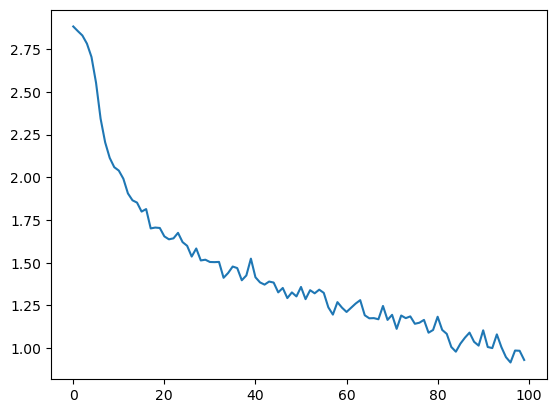

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluate Results

C:\Users\rober\AppData\Local\Temp\ipykernel_8184\3646947725.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\rober\AppData\Local\Temp\ipykernel_8184\3646947725.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


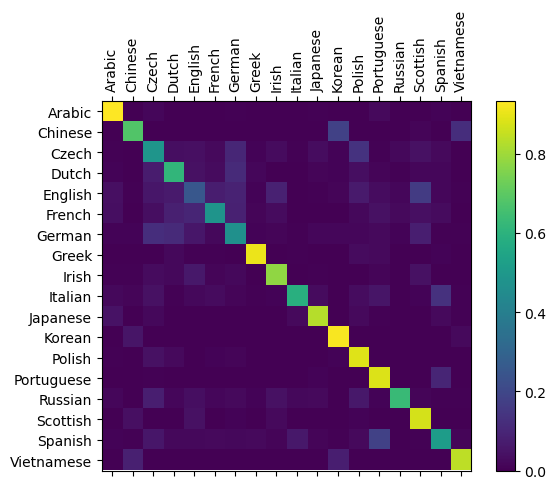

In [21]:
# Set random seed for Python
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = basic_rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        with torch.no_grad():
            output, hidden = basic_rnn(line_tensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    prediction, prediction_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][prediction_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Make Predictions on User Input

In [22]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(lineToTensor(input_line))

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dostoevsky')
predict('Doveski')
predict('Jackson')
predict('Satoshi')
predict('Giorgos')
predict('Apostolopoulos')
predict('Brosnan')
predict('Connery')


> Dostoevsky
(-0.52) Russian
(-1.29) Czech
(-2.29) English

> Doveski
(-1.46) Japanese
(-1.48) Polish
(-1.66) Italian

> Jackson
(-0.01) Scottish
(-5.23) English
(-5.45) Polish

> Satoshi
(-0.49) Japanese
(-1.83) Italian
(-2.17) Polish

> Giorgos
(-0.26) Scottish
(-2.52) Spanish
(-3.41) Arabic

> Apostolopoulos
(-0.03) Greek
(-4.11) Polish
(-5.28) Spanish

> Brosnan
(-1.02) Czech
(-1.28) English
(-2.27) German

> Connery
(-0.52) Irish
(-1.59) French
(-2.23) Scottish


# Define LSTM RNN

LSTM layer is used in place of the RNN's linear hidden layer.

In [23]:
import torch.nn as nn

class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_RNN, self).__init__()

        # Replace nn.Linear and nn.Tanh with nn.LSTM
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

        # output layer
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, atminus1, htminus1):
        # Forward propagate
        output, (at, ht) = self.lstm(input, (atminus1, htminus1))

        # Pass through output layer to get predictions
        output = self.h2o(ht)
        output = self.softmax(output)

        return output, at, ht

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm_rnn = LSTM_RNN(n_letters, n_hidden, n_categories)

# Training Function

In [24]:
learning_rate = 0.05
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_rnn.parameters(), lr = learning_rate)

def train_LSTM_RNN(category_tensor, line_tensor):
    atminus1, htminus1 = lstm_rnn.initHidden()

    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        input_char = line_tensor[i]
        output, atminus1, htminus1  = lstm_rnn(input_char, atminus1, htminus1)

    # Calculate loss using final output
    loss = criterion(output, category_tensor)

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    return output, loss.item()

# Training Loop

In [26]:
# Set random seed for Python
random_seed = 0
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

n_iters = 100000
print_every = 5000

plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # Get training data samples from randomTrainingExample, then use train_LSTM_RNN to
    # obtain output and loss, accumulate loss in current_loss
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, = train_LSTM_RNN(category_tensor, line_tensor)
    current_loss += loss

    # Print iteration number, loss, name and prediction
    if iter % print_every == 0:
        prediction, prediction_i = categoryFromOutput(output)
        correct = '✓' if prediction == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start),
                                                loss, line, prediction, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 6.8342 Gajos / Greek ✗ (Polish)
10000 10% (0m 45s) 2.1167 D'cruze / French ✗ (Portuguese)
15000 15% (1m 12s) 1.6747 Yosano / Italian ✗ (Japanese)
20000 20% (1m 35s) 1.2306 Blecher / German ✓
25000 25% (2m 0s) 2.5685 Black / Polish ✗ (Scottish)
30000 30% (2m 31s) 0.0432 Adamidis / Greek ✓
35000 35% (2m 57s) 0.0002 Kouropoulos / Greek ✓
40000 40% (3m 20s) 0.7112 Arendonk / Dutch ✓
45000 45% (3m 44s) 1.0139 Holub / German ✗ (Czech)
50000 50% (4m 8s) 0.0083 Perreault / French ✓
55000 55% (4m 31s) 2.0031 Sai / Chinese ✗ (Vietnamese)
60000 60% (4m 54s) 1.6402 Mori / Italian ✗ (Japanese)
65000 65% (5m 20s) 3.7690 Tso / Vietnamese ✗ (Chinese)
70000 70% (5m 44s) 0.0409 Shamon / Arabic ✓
75000 75% (6m 8s) 1.0757 Otani / Italian ✗ (Japanese)
80000 80% (6m 33s) 0.0097 Tahan / Arabic ✓
85000 85% (6m 56s) 0.0010 Papoutsis / Greek ✓
90000 90% (7m 20s) 1.5632 Forster / French ✗ (English)
95000 95% (7m 47s) 0.0223 Klerkx / Dutch ✓
100000 100% (8m 11s) 0.0220 Plourde / French ✓


# Plot Results

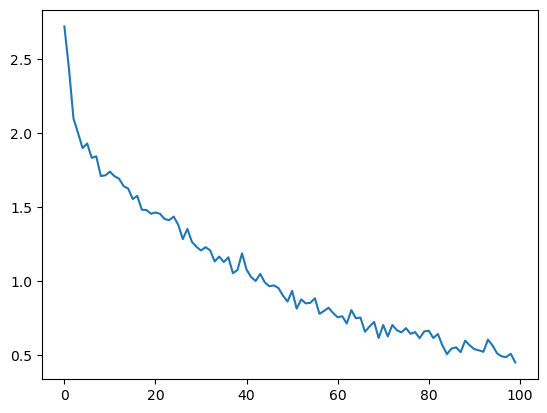

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluate Results

C:\Users\rober\AppData\Local\Temp\ipykernel_8184\1814499653.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\rober\AppData\Local\Temp\ipykernel_8184\1814499653.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


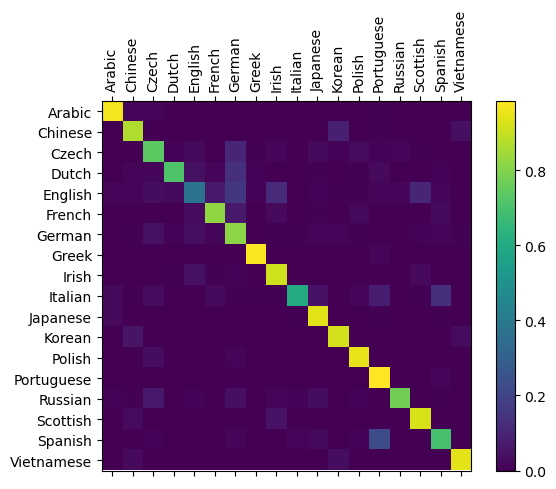

In [28]:
# Set random seed for Python
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_lstm(line_tensor):
    atminus1, htminus1 = lstm_rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        with torch.no_grad():
            output_lstm, at, ht = lstm_rnn(line_tensor[i], atminus1, htminus1)
            atminus1 = at
            htminus1 = ht
    return output_lstm

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_lstm = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output_lstm)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Make Predictions on User Input

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output_lstm = evaluate(lineToTensor(input_line))

    # Get top N categories
    topv, topi = output_lstm.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dostoevsky')
predict('Doveski')
predict('Jackson')
predict('Satoshi')
predict('Giorgos')
predict('Apostolopoulos')
predict('Brosnan')
predict('Connery')


> Dostoevsky
(-0.52) Russian
(-1.29) Czech
(-2.29) English

> Doveski
(-1.46) Japanese
(-1.48) Polish
(-1.66) Italian

> Jackson
(-0.01) Scottish
(-5.23) English
(-5.45) Polish

> Satoshi
(-0.49) Japanese
(-1.83) Italian
(-2.17) Polish

> Giorgos
(-0.26) Scottish
(-2.52) Spanish
(-3.41) Arabic

> Apostolopoulos
(-0.03) Greek
(-4.11) Polish
(-5.28) Spanish

> Brosnan
(-1.02) Czech
(-1.28) English
(-2.27) German

> Connery
(-0.52) Irish
(-1.59) French
(-2.23) Scottish
